In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error



from sklearn.feature_selection import RFE
import statsmodels.formula.api as smf


In [19]:
df = pd.read_csv('cleaned_data.csv')


## Which genre is more profitable? 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


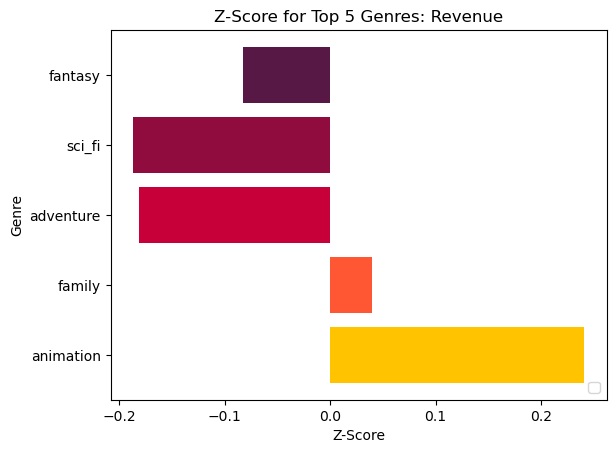

In [20]:
df["title_year"] = df["title_year"].astype(int)
df_rev = df.copy()
# Define top 5 genres
top_5 = ['animation', 'family', 'adventure', 'sci_fi', 'fantasy']

# Drop irrelevant columns
df_rev = df_rev.drop(columns=['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western'])

# Format year column
df_rev['title_year'] = df_rev['title_year'].astype(str).str.extract('(\d{4})', expand=False).astype(float)

# Filter by top 5 genres
df_rev = df_rev[top_5 + ['title_year', 'gross']]
df_rev = pd.melt(df, id_vars=['title_year', 'gross'], value_vars=top_5, var_name='genre', value_name='dummy_value')
df_rev = df_rev[df_rev['dummy_value'] == 1]
df_rev = df_rev.drop(columns=['dummy_value'])

# Calculate z-score for gross profit
df_rev['z_score'] = (df_rev['gross'] - df_rev['gross'].mean()) / df_rev['gross'].std()

# Group by year and genre and calculate mean z-score
grouped = df_rev.groupby(['title_year', 'genre']).agg({'z_score': np.mean}).reset_index()

# Condense each of the 5 genres into 1 horizontal bar, use nice colors
for i, genre in enumerate(top_5):
    genre_df = grouped[grouped['genre'] == genre]
    plt.barh(y=i, width=genre_df['z_score'].mean(), color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'][i])   

# Set plot properties
plt.yticks(range(len(top_5)), top_5)
plt.title('Z-Score for Top 5 Genres: Revenue')
plt.xlabel('Z-Score')
plt.ylabel('Genre')
plt.legend(loc='lower right')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


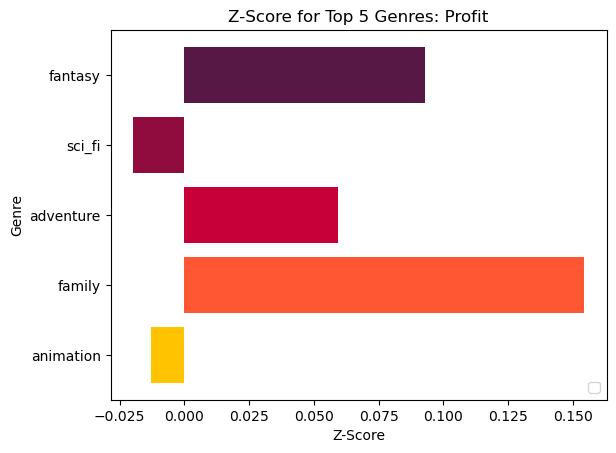

In [21]:
#Do same for profit
df_prof = df.copy()
# Define top 5 genres
top_5 = ['animation', 'family', 'adventure', 'sci_fi', 'fantasy']

# Drop irrelevant columns
df_prof = df_prof.drop(columns=['action', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'history', 'horror', 'music', 'musical', 'mystery', 'romance', 'sport', 'thriller', 'war', 'western'])

# Format year column
df_prof['title_year'] = df_prof['title_year'].astype(int)

# Filter by top 5 genres
df_prof = df_prof[top_5 + ['title_year', 'profit']]
df_prof = pd.melt(df, id_vars=['title_year', 'profit'], value_vars=top_5, var_name='genre', value_name='dummy_value')
df_prof = df_prof[df_prof['dummy_value'] == 1]
df_prof = df_prof.drop(columns=['dummy_value'])

# Calculate z-score for gross profit
df_prof['z_score'] = (df_prof['profit'] - df_prof['profit'].mean()) / df_prof['profit'].std()

# Group by year and genre and calculate mean z-score
grouped = df_prof.groupby(['title_year', 'genre']).agg({'z_score': np.mean}).reset_index()

# Condense each of the 5 genres into 1 horizontal bar, use nice colors
for i, genre in enumerate(top_5):
    genre_df = grouped[grouped['genre'] == genre]
    plt.barh(y=i, width=genre_df['z_score'].mean(), color=['#FFC300', '#FF5733', '#C70039', '#900C3F', '#581845'][i])

# Set plot properties   
plt.yticks(range(len(top_5)), top_5)
plt.title('Z-Score for Top 5 Genres: Profit')
plt.xlabel('Z-Score')
plt.ylabel('Genre')
plt.legend(loc='lower right')
plt.show()




# Model Development


In [22]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [23]:
# create bins based on quartiles of the "gross" variable
train['gross_bins'], bins = pd.qcut(train['gross'], q=4, retbins=True, labels=False)

# normalize "gross_bins" to have values in the range [0, 1]
train['gross_bins'] = (train['gross_bins'] - np.min(train['gross_bins'])) / (np.max(train['gross_bins']) - np.min(train['gross_bins']))

test['gross_bins'] = pd.cut(test['gross'], bins=bins, labels=False)
test['gross_bins'] = (test['gross_bins'] - np.min(test['gross_bins'])) / (np.max(test['gross_bins']) - np.min(test['gross_bins']))


In [24]:
#values in gross_)bins
train['gross_bins'].value_counts()

0.000000    2248
0.666667    2247
0.333333    2247
1.000000    2247
Name: gross_bins, dtype: int64

### Logistic Regression  : gross revenue

In [25]:

gross_genre = smf.logit(formula = 'gross_bins ~ animation + family + adventure + sci_fi + fantasy', data = train).fit() 
gross_genre.summary()


Optimization terminated successfully.
         Current function value: 0.673638
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             gross_bins   No. Observations:                 8989
Model:                          Logit   Df Residuals:                     8983
Method:                           MLE   Df Model:                            5
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                 0.02815
Time:                        12:15:17   Log-Likelihood:                -6055.3
converged:                       True   LL-Null:                       -6230.7
Covariance Type:            nonrobust   LLR p-value:                 1.212e-73
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1688      0.024     -7.059      0.000      -0.216      -0.122
animation      1.0018      0.171      5.856      0.000       0.666       1.337
family         1.0368      0.117      8.826      0.000       0.807       1.267
adventure      0.8892      0.090      9.923      0.000       0.714       1.065
sci_fi         0.5695      0.104      5.454      0.000       0.365       0.774
fantasy        0.6105      0.104      5.858      0.000       0.406       0.815
==============================================================================
"""

In [26]:
# predict the values for the test set using the trained model
y_pred = gross_genre.predict(test)

# convert predicted probabilities to class labels (0 or 1)
y_pred_class = np.where(y_pred > 0.5, 1, 0)

# compare predicted class labels with actual class labels in the test set
accuracy = np.mean(y_pred_class == test['gross_bins'])
print('Accuracy:', accuracy)

Accuracy: 0.31494661921708184


### Logistic Regression: Profit

In [27]:
# create bins based on quartiles of the "gross" variable
train['profit'], bins = pd.qcut(train['profit'], q=4, retbins=True, labels=False)

# normalize "gross_bins" to have values in the range [0, 1]
train['profit'] = (train['profit'] - np.min(train['profit'])) / (np.max(train['profit']) - np.min(train['profit']))

test['profit'] = pd.cut(test['profit'], bins=bins, labels=False)
test['profit'] = (test['profit'] - np.min(test['profit'])) / (np.max(test['profit']) - np.min(test['profit']))


In [28]:
 
profit_genre = smf.logit(formula = 'profit ~ animation + family + adventure + sci_fi + fantasy', data = train).fit() #Developing logistic regression model



Optimization terminated successfully.
         Current function value: 0.691974
         Iterations 4


In [29]:
# predict  values for the test set using the trained model
y_pred = profit_genre.predict(test)

# convert predicted probabilities to class labels (0 or 1)
y_pred_class = np.where(y_pred > 0.5, 1, 0)

# compare predicted class labels with actual class labels in the test set
accuracy = np.mean(y_pred_class == test['profit'])
print('Accuracy:', accuracy)


Accuracy: 0.2557829181494662


### Linear Regrssion : Profit 

In [30]:
#gross profit linear regression model with genres
profit_linear_model = smf.ols(formula = 'gross ~ animation + family + adventure + sci_fi + fantasy', data = train).fit() 
profit_linear_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.066
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     126.1
Date:                Sun, 05 Mar 2023   Prob (F-statistic):          1.69e-129
Time:                        12:15:17   Log-Likelihood:            -1.7528e+05
No. Observations:                8989   AIC:                         3.506e+05
Df Residuals:                    8983   BIC:                         3.506e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.745e+07   8.48e+05     55.940      0.000    4.58e+07    4.91e+07
animation   5.618e+07   5.61e+06     10.022      0.000    4.52e+07    6.72e+07
family      4.264e+07   3.83e+06     11.129      0.000    3.51e+07    5.01e+07
adventure   5.452e+07   3.01e+06     18.134      0.000    4.86e+07    6.04e+07
sci_fi      3.448e+07   3.65e+06      9.457      0.000    2.73e+07    4.16e+07
fantasy     3.734e+07   3.62e+06     10.302      0.000    3.02e+07    4.44e+07
==============================================================================
Omnibus:                     5196.831   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54886.590
Skew:                           2.618   Prob(JB):                         0.00
Kurtosis:                      13.914   Cond. No.                         7.53
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
# select the genres with the highest coefficients in the linear regression model
selected_genres = profit_linear_model.params.sort_values(ascending=False)[:2].index.tolist()

print('Selected genres:', selected_genres)

Selected genres: ['animation', 'adventure']


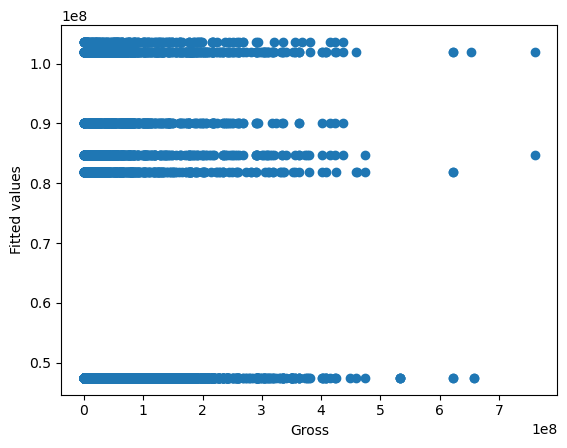

In [32]:
#plot linear regression model fit for selected genres
plt.scatter(train['gross'], profit_linear_model.fittedvalues)
plt.xlabel('Gross')
plt.ylabel('Fitted values')
plt.show()

